In [ ]:
import tensorflow as tf
print(tf.__version__)


2.17.0


146/146 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.9256 - loss: 0.2214 - val_accuracy: 0.9665 - val_loss: 0.0808


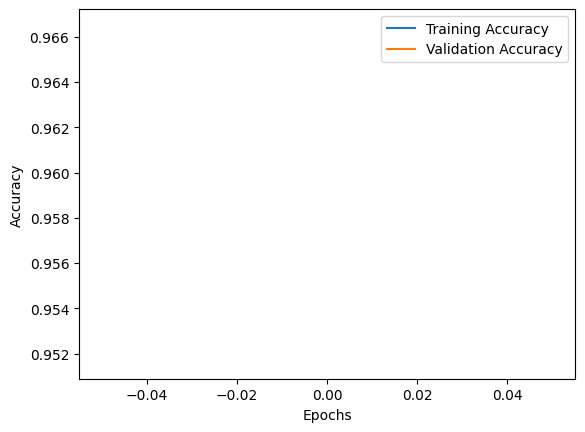

73/73 ━━━━━━━━━━━━━━━━━━━━ 48s 658ms/step - accuracy: 0.9642 - loss: 0.0807
Validation Accuracy: 0.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


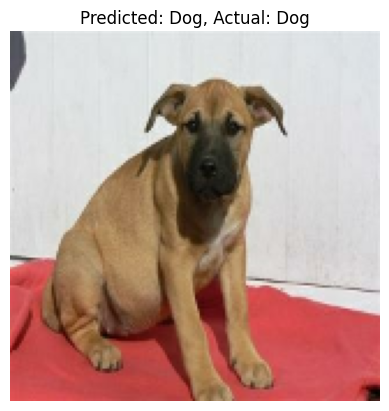

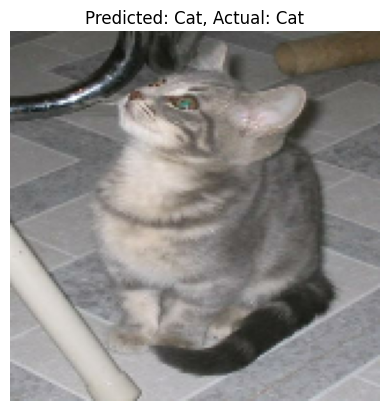

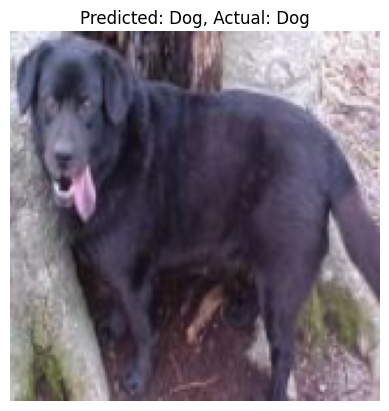

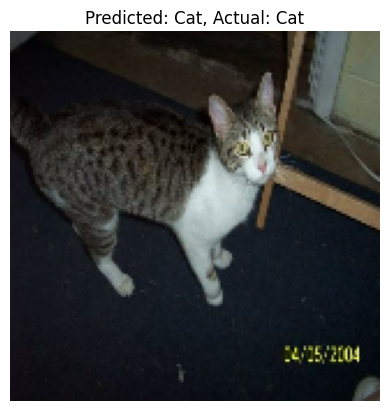

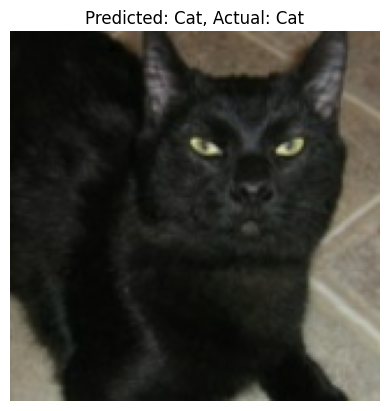

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


(ds_train, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:20%]', 'train[20%:30%]'],
    with_info=True,
    as_supervised=True
)


IMG_SIZE = (160, 160)
BATCH_SIZE = 32

def preprocess_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

ds_train = ds_train.map(preprocess_image).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.map(preprocess_image).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
for layer in base_model.layers:
    layer.trainable = False

x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)


model = tf.keras.models.Model(inputs=base_model.input, outputs=x)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(
    ds_train,
    epochs=1,
    validation_data=ds_val
)


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

val_loss, val_acc = model.evaluate(ds_val)
print(f'Validation Accuracy: {val_acc:.2f}')


for images, labels in ds_val.take(1):
    predictions = model.predict(images)
    for i in range(5):
        plt.imshow(images[i].numpy())
        plt.title(f"Predicted: {'Dog' if predictions[i] > 0.5 else 'Cat'}, Actual: {'Dog' if labels[i] == 1 else 'Cat'}")
        plt.axis('off')
        plt.show()
